In [5]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
import joblib

In [6]:
data = pd.read_csv('train.csv')
# Selecting the columns to be scaled (all except date and time columns)
columns_to_scale = data.columns.difference(['Year', 'Month', 'Day', 'Hour', 'Minute'])

# Applying Min-Max Scaling
scaler = MinMaxScaler()
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

data['DateTime'] = pd.to_datetime(data[['Year', 'Month', 'Day', 'Hour', 'Minute']])
data = data.set_index('DateTime')

# Drop the original columns if they are no longer needed
data.drop(['Year', 'Month', 'Day', 'Hour', 'Minute'], axis=1, inplace=True)

In [7]:
# Define a function to create sequences from the dataset
def create_sequences(data, window_size, target_column):
    sequences = []
    targets = []

    data_X = data.drop(target_column, axis=1)

    for i in range(len(data) - window_size):
        sequence = data_X.iloc[i:i + window_size].to_numpy()
        target = data.iloc[i + window_size][target_column].reshape(1,)
        
        sequences.append(sequence)
        targets.append(target)

    return np.array(sequences), np.array(targets)

# Target column for prediction
target_column = 'Clearsky GHI'

In [8]:
# 1D CNN DATA

# Choosing a window size
window_size = 24

# Creating sequences
X_cnn, y_cnn = create_sequences(data, window_size, target_column)

# Displaying the shape of the created sequences and targets
X_cnn.shape, y_cnn.shape

((175272, 24, 12), (175272, 1))

In [9]:
# LSTM DATA

# Choosing a window size
window_size = 96

# Creating sequences
X_lstm, y_lstm = create_sequences(data, window_size, target_column)

# Displaying the shape of the created sequences and targets
X_lstm.shape, y_lstm.shape

((175200, 96, 12), (175200, 1))

In [10]:
# Random Forest DATA

# Random Forest does not require sequences to be created so we can directly use the data
X_rf = data.drop(['Clearsky GHI','Clearsky DHI','Clearsky DNI'], axis=1)
y_rf = data[target_column].to_numpy().reshape(-1, 1)

# Displaying the shape of the created sequences and targets
X_rf.shape, y_rf.shape

((175296, 10), (175296, 1))

In [11]:
# CNN data is longer that the LSTM data because of the window size chosen. let's trim the CNN data to match the length of the LSTM data
X_cnn = X_cnn[:len(X_lstm)]
y_cnn = y_cnn[:len(y_lstm)]

X_rf = X_rf[:len(X_lstm)]
y_rf = y_rf[:len(y_lstm)]

In [12]:
# Check if GPU is available and move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
from torch.utils.data import TensorDataset, DataLoader

# Create a TensorDataset for CNN
X_test_tensor_cnn = torch.tensor(X_cnn).float().to(device)
y_test_tensor_cnn = torch.tensor(y_cnn).float().to(device)

test_dataset_cnn = TensorDataset(X_test_tensor_cnn, y_test_tensor_cnn)

test_loader_cnn = DataLoader(dataset=test_dataset_cnn, batch_size=32, shuffle=False)

# Create a TensorDataset for LSTM
X_test_tensor_lstm = torch.tensor(X_lstm).float().to(device)
y_test_tensor_lstm = torch.tensor(y_lstm).float().to(device)

test_dataset_lstm = TensorDataset(X_test_tensor_lstm, y_test_tensor_lstm)

test_loader_lstm = DataLoader(dataset=test_dataset_lstm, batch_size=32, shuffle=False)

In [14]:
import torch.nn.functional as F
from torch import nn

# Define the CNN model
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=24, out_channels=64, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128, 100)  # Adjusted input size
        self.fc2 = nn.Linear(100, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Load the model
weights_1DCNN = torch.load('best_model.pth')

# Create an instance of the model with the same parameters as the original model
model_cnn = CNN1D()

# Load the weights
model_cnn.load_state_dict(weights_1DCNN)

<All keys matched successfully>

In [15]:
from torch.optim import Adam

# Define the LSTM model
class Model(nn.Module):
    def __init__(self, lr):
        super(Model, self).__init__()
        self.lstm = nn.LSTM(input_size=12, hidden_size=32, batch_first=True)
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.loss_function = nn.MSELoss()
        self.optimizer = Adam(self.parameters(), lr=lr)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return x

    def compile(self, x, y):
        self.optimizer.zero_grad()
        output = self.forward(x)
        loss = self.loss_function(output, y)
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
# Load the model
weights_LSTM = torch.load('0.0002LSTM.pth')

# Create an instance of the model with the same parameters as the original model
model_lstm = Model(lr=0.001)

# Load the weights
model_lstm.load_state_dict(weights_LSTM)

<All keys matched successfully>

In [16]:
rf_model = joblib.load('6-39e-05.joblib')

In [17]:
model_cnn.to(device)
model_lstm.to(device)

Model(
  (lstm): LSTM(12, 32, batch_first=True)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (loss_function): MSELoss()
)

In [32]:
#mse_values = [0.000008, 0.00002, 0.00006]
mse_values = [3.9898704676470736e-05, 0.09130962199219195, 0.30392009913387796]

# Calculate weights as the inverse of MSE, then normalize
inverse_mse = [1/mse for mse in mse_values]
sum_inverse_mse = sum(inverse_mse)
weights = [inv_mse/sum_inverse_mse for inv_mse in inverse_mse]
weights

[0.9994320818983187, 0.0004367124144185068, 0.00013120568726284135]

In [33]:
# Function to make predictions with a model
def predict_with_model(model, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            outputs = model(data)
            predictions.extend(outputs.cpu().numpy())
    return np.array(predictions)

# Predict using CNN and LSTM models
cnn_predictions = predict_with_model(model_cnn, test_loader_cnn)
lstm_predictions = predict_with_model(model_lstm, test_loader_lstm)
rf_predictions = rf_model.predict(X_rf)

# Average LSTM predictions across each window
avg_lstm_predictions = lstm_predictions.mean(axis=1)

# Now, reshape to match the CNN predictions
avg_lstm_predictions = avg_lstm_predictions.reshape(-1, 1)

# Apply weights to the predictions
weighted_cnn_predictions = cnn_predictions * weights[0]
weighted_lstm_predictions = avg_lstm_predictions * weights[1]
weighted_rf_predictions = rf_predictions * weights[2] 
weighted_rf_predictions = weighted_rf_predictions.reshape(-1,1)


In [20]:
# Combine the predictions
final_predictions = weighted_cnn_predictions + weighted_lstm_predictions + weighted_rf_predictions

In [21]:
from sklearn.metrics import mean_squared_error

# Assuming y_test contains the true values (you'll need to concatenate y_cnn and y_lstm appropriately)
mean_squared_error(y_cnn, final_predictions)

0.015433386269217446

In [22]:
mean_squared_error(y_cnn, cnn_predictions)

3.9898704676470736e-05

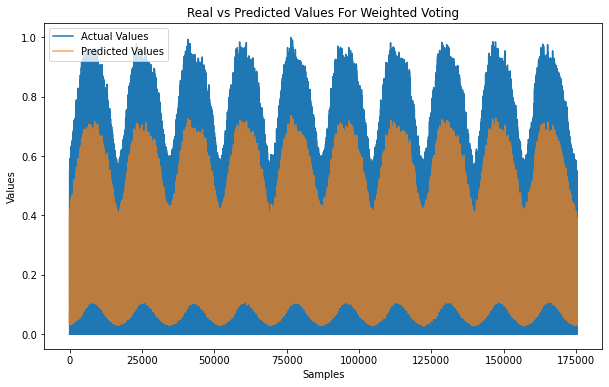

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_lstm, label='Actual Values')
plt.plot(final_predictions, label='Predicted Values', alpha=0.7)
plt.title('Real vs Predicted Values For Weighted Voting')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.show()

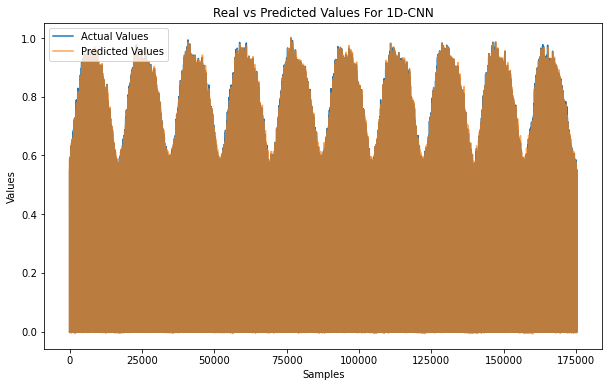

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(y_lstm, label='Actual Values')
plt.plot(cnn_predictions, label='Predicted Values', alpha=0.7)
plt.title('Real vs Predicted Values For 1D-CNN')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.show()